In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
from abc import ABC, abstractmethod
# Variations of AIMD
class TCPReno():
    '''
    Alpha and Beta are 1 and 0.5 respectively
    '''
    def __init__(self, cwnd):
        self.cwnd = cwnd
        self.RTT_tracker = [cwnd]
    
    def AI(self):
        self.cwnd += 1
        self.RTT_tracker.append(self.cwnd)
    
    def MD(self):
        self.cwnd = math.floor(self.cwnd * 0.5)
        self.RTT_tracker.append(self.cwnd)


class GAIMD():
    '''
    Generaic AIMD -> Adjustable Alpha and Beta
    Linear
    '''
    def __init__(self, alpha, beta, cwnd):
        self.alpha = alpha
        self.beta = beta
        self.cwnd = cwnd
        self.RTT_tracker = [cwnd]
    
    def AI(self):
        self.cwnd = math.floor(self.cwnd + self.alpha)
        self.RTT_tracker.append(self.cwnd)
    
    def MD(self):
        self.cwnd = math.floor(self.cwnd * self.beta)
        self.RTT_tracker.append(self.cwnd)

class NonLinearAIMD(ABC):
    '''
    Non-Linear TCP with different non-linear increment functions
    '''
    def __init__(self, alpha, beta, cwnd, ssthresh):
        self.alpha = alpha
        self.beta = beta
        self.cwnd = cwnd
        self.ssthresh = ssthresh
        self.RTT_tracker = [cwnd]
    
    @abstractmethod
    def update_AI(self):
        pass

    @abstractmethod
    def update_MD(self):
        '''
        For better control of adjustments to variables -> Mostly Beta variable
        '''
        pass

    def AI(self):
        if self.cwnd < self.ssthresh:
            self.update_AI()
        self.cwnd = math.floor(self.cwnd + self.alpha)
        

        self.RTT_tracker.append(self.cwnd)
    
    def MD(self):
        self.update_MD()
        self.cwnd = math.floor(self.cwnd * self.beta)
        self.RTT_tracker.append(self.cwnd)

class ExponentialAIMD(NonLinearAIMD):
    def __init__(self, alpha, beta, cwnd, ssthresh, exponent):
        super().__init__(alpha, beta, cwnd, ssthresh)
        self.exponent = exponent
        self.original_alpha = alpha
        self.original_beta = beta
        
    def update_AI(self):
        self.alpha *= math.pow(self.cwnd, self.exponent)
    
    def update_MD(self):
        self.alpha = 1

class LogAIMD(NonLinearAIMD):        
    def __init__(self, alpha, beta, cwnd, ssthresh):
        super().__init__(alpha, beta, cwnd, ssthresh)
        self.original_alpha = alpha
        self.original_beta = beta
        
    def update_AI(self):
        self.alpha *= math.log(self.cwnd+1)
    
    def update_MD(self):
        self.alpha = self.original_alpha



In [4]:
class Network():
    def __init__(self, capacity, users):
        self.capacity = capacity
        self.users = users
        # self.prev_congested_cwnd = None
        # self.convergence_RTT = None

    
    def run_one_RTT(self):
        c_sum = 0
        for user in self.users:
            c_sum += user.cwnd
        
        if c_sum <= self.capacity:
            # print('Additive I')
            for user in self.users:
                user.AI()
        
        else:
            print(f'Multiplicative D at {len(self.users[0].RTT_tracker)-1}')
            # # Check most recent cwnd and prev congested cwnd
            # if self.users[0].RTT_tracker[-1] != self.prev_congested_cwnd:
            #     # Update RTT
            #     self.convergence_RTT = len(self.users[0].RTT_tracker) - 1
            #     # Update prev congested cwnd
            #     self.prev_congested_cwnd = self.users[0].RTT_tracker[-1]
            for user in self.users:
                user.MD()
    
    def find_convergence(self):
        # Find index of most common value that is the highest
        u = self.users[0]
        
    
    def visualise(self, name=None):
        '''
        Only shows the first 2 users
        '''
        plt.plot(self.users[0].RTT_tracker, self.users[1].RTT_tracker)
        
        plt.plot([0, self.capacity], [self.capacity, 0], 'k-', label='Efficiency Line')
        
        # Equal fariness
        plt.plot([0, self.capacity], [0, self.capacity], 'g', linestyle='dashed', label='Fairness Line')
        plt.xlabel("User 1")
        plt.ylabel("User 2")
        plt.title(f"{name}")
        plt.legend()
        plt.show()
    
    def visualiseRTT(self, name=None):
        x = [i for i in range(len(self.users[0].RTT_tracker))]
        for i, u in enumerate(self.users):
            plt.plot(x, u.RTT_tracker, label=f"User {i+1}")

        plt.xlabel("RTT")
        plt.ylabel("CWND")
        plt.title(f"{name}")
        plt.legend()
        plt.show()

In [5]:
def run_simulation(ITERATESMAX, C, users, name):
    print("*"*20 +f" {name} " + "*"*20)

    # Display the initial values
    for i, u in enumerate(users):
        print(f"Initial User-{i+1} CWND:", u.RTT_tracker[0])

    # Simulate the network
    network = Network(C, users)
    for i in range(1, ITERATESMAX):
        network.run_one_RTT()

    # Display the final values
    for i, u in enumerate(users):
        print(f"Final User-{i+1} CWND:", u.RTT_tracker[-1])

    # print(f"Convergence RTT: {network.convergence_RTT}")
    network.visualise(name)
    network.visualiseRTT(name)


******************** Standard AIMD ********************
Initial User-1 CWND: 10
Initial User-2 CWND: 20
Multiplicative D at 36
Multiplicative D at 62
Multiplicative D at 89
Multiplicative D at 115
Multiplicative D at 142
Multiplicative D at 169
Multiplicative D at 196
Final User-1 CWND: 27
Final User-2 CWND: 27


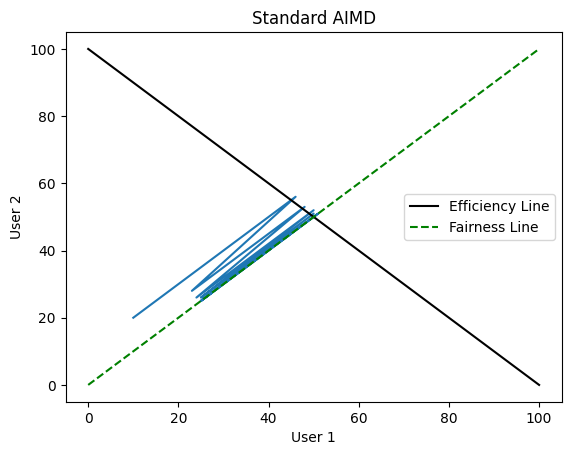

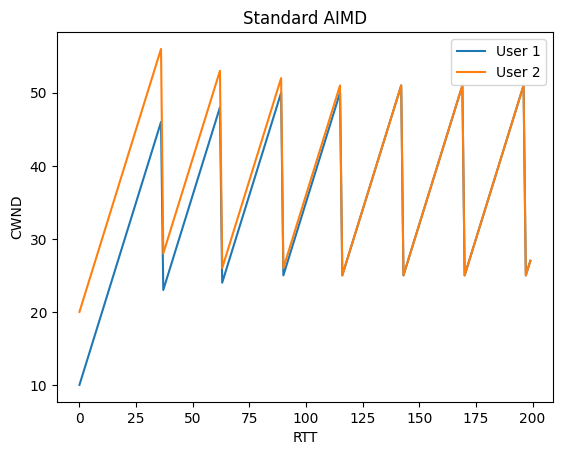

In [6]:
# Standard
ITERATESMAX = 200 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# Users
ALPHA = 1
BETA = 0.5

# TCP Reno Users
num_users = 2
users = [TCPReno(10), TCPReno(20)]
name = "Standard AIMD"

run_simulation(ITERATESMAX, C, users, name)


Slow convergence however quite stable (MD every 27 RTTs)

******************** Aggressive  GAIMD ********************
Initial User-1 CWND: 10
Initial User-2 CWND: 100
Multiplicative D at 0
Multiplicative D at 2
Multiplicative D at 4
Multiplicative D at 6
Multiplicative D at 8
Multiplicative D at 10
Multiplicative D at 13
Multiplicative D at 15
Multiplicative D at 17
Multiplicative D at 19
Multiplicative D at 21
Multiplicative D at 23
Multiplicative D at 25
Multiplicative D at 27
Multiplicative D at 30
Multiplicative D at 32
Multiplicative D at 34
Multiplicative D at 36
Multiplicative D at 38
Multiplicative D at 40
Multiplicative D at 42
Multiplicative D at 44
Multiplicative D at 47
Multiplicative D at 49
Multiplicative D at 51
Multiplicative D at 53
Multiplicative D at 55
Multiplicative D at 57
Multiplicative D at 59
Multiplicative D at 62
Multiplicative D at 64
Multiplicative D at 66
Multiplicative D at 68
Multiplicative D at 70
Multiplicative D at 72
Multiplicative D at 74
Multiplicative D at 77
Multiplicative D at 79
Multiplicative D at 81

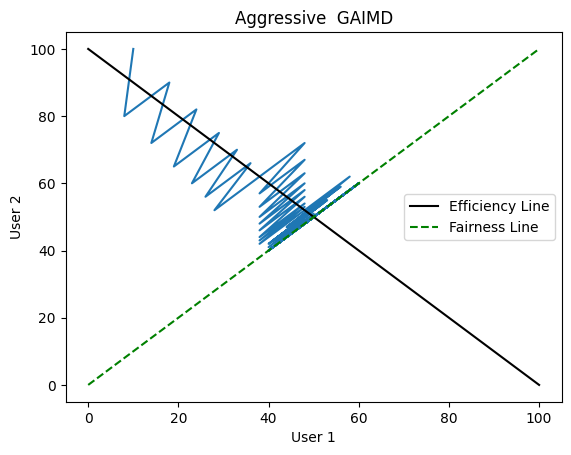

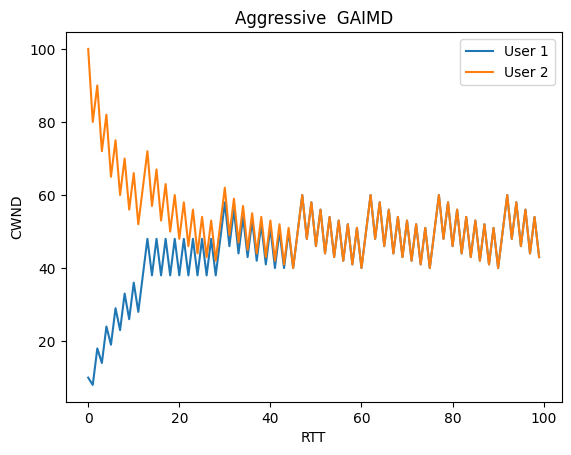

In [22]:
# Aggressive GAIMD
ITERATESMAX = 100 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# Params
ALPHA = 1
BETA = 0.5

alphas = [0.1*C, 0.1*C]

betas = [0.8, 0.8]

init_cwnds = [10, 100]

# ssthresholds = [float('inf'), float('inf')]

# exponents = [1/3, 1/3]

# Users
num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(GAIMD(alphas[i], betas[i], init_cwnds[i]))

name = "Aggressive  GAIMD"

run_simulation(ITERATESMAX, C, users, name)

******************** Friendly  GAIMD ********************
Initial User-1 CWND: 10
Initial User-2 CWND: 100
Multiplicative D at 0
Multiplicative D at 41
Multiplicative D at 83
Multiplicative D at 125
Multiplicative D at 167
Multiplicative D at 209
Multiplicative D at 251
Multiplicative D at 293
Final User-1 CWND: 15
Final User-2 CWND: 15


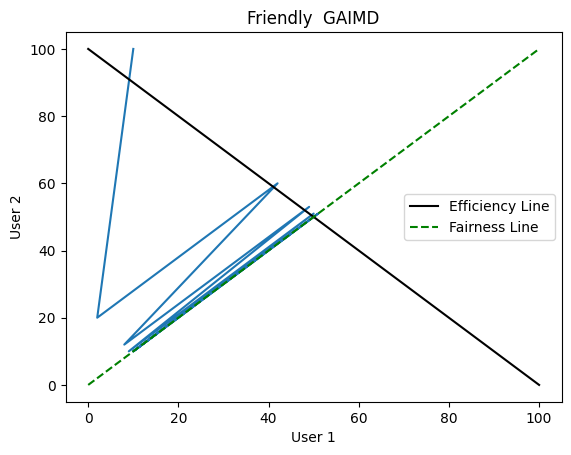

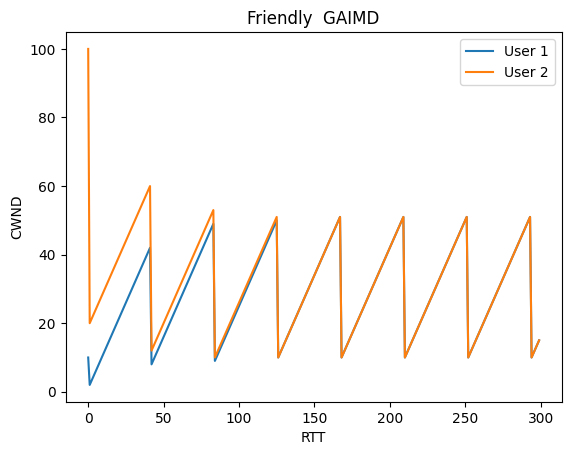

In [23]:
# Friendly GAIMD
ITERATESMAX = 300 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# Params
ALPHA = 1
BETA = 0.5

alphas = [1, 1]

betas = [0.2, 0.2]

init_cwnds = [10, 100]

# ssthresholds = [float('inf'), float('inf')]

# exponents = [1/3, 1/3]

# Users
num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(GAIMD(alphas[i], betas[i], init_cwnds[i]))

name = "Friendly  GAIMD"
run_simulation(ITERATESMAX, C, users, name)

******************** Mixed  GAIMD - Alpha = [1, 10.0]; Beta = [0.2, 0.8] ********************
Initial User-1 CWND: 10
Initial User-2 CWND: 20
Multiplicative D at 7
Multiplicative D at 11
Multiplicative D at 14
Multiplicative D at 17
Multiplicative D at 20
Multiplicative D at 23
Multiplicative D at 26
Multiplicative D at 29
Multiplicative D at 32
Multiplicative D at 35
Multiplicative D at 38
Multiplicative D at 41
Multiplicative D at 44
Multiplicative D at 47
Multiplicative D at 50
Multiplicative D at 53
Multiplicative D at 56
Multiplicative D at 59
Multiplicative D at 62
Multiplicative D at 65
Multiplicative D at 68
Multiplicative D at 71
Multiplicative D at 74
Multiplicative D at 77
Multiplicative D at 80
Multiplicative D at 83
Multiplicative D at 86
Multiplicative D at 89
Multiplicative D at 92
Multiplicative D at 95
Multiplicative D at 98
Multiplicative D at 101
Multiplicative D at 104
Multiplicative D at 107
Multiplicative D at 110
Multiplicative D at 113
Multiplicative D at 116
Mu

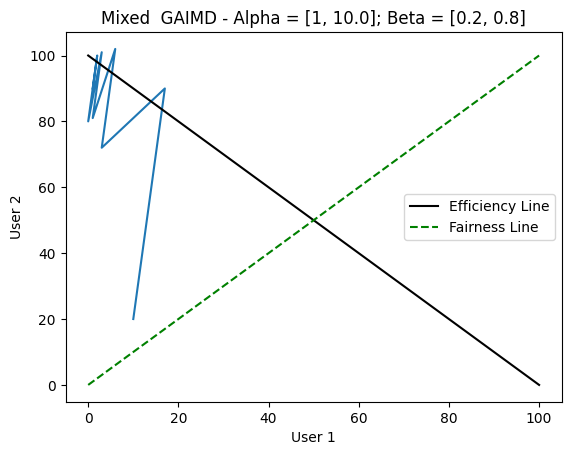

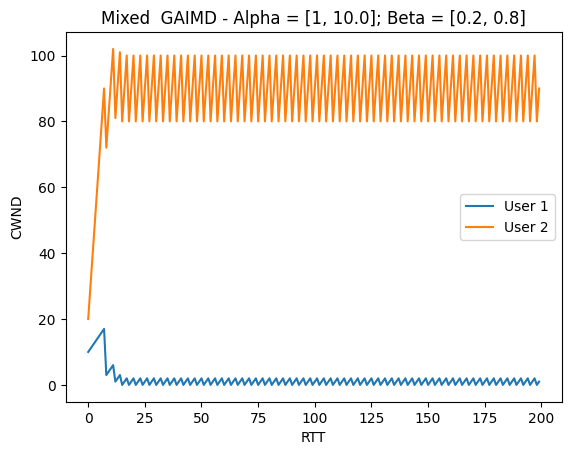

In [38]:
# Mixed GAIMD
# User 2 is more agreesive
ITERATESMAX = 200 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# Params
ALPHA = 1
BETA = 0.5

alphas = [1, 0.1*C]

betas = [0.2, 0.8]

init_cwnds = [10, 20]

# ssthresholds = [float('inf'), float('inf')]

# exponents = [1/3, 1/3]

# Users
num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(GAIMD(alphas[i], betas[i], init_cwnds[i]))

name = f"Mixed  GAIMD - Alpha = {alphas}; Beta = {betas}"

run_simulation(ITERATESMAX, C, users, name)

# print(users[0].RTT_tracker)

******************** Mixed  GAIMD V2 - Alpha = [1, 10.0]; Beta = [0.8, 0.2] ********************
Initial User-1 CWND: 10
Initial User-2 CWND: 100
Multiplicative D at 0
Multiplicative D at 8
Multiplicative D at 16
Multiplicative D at 24
Multiplicative D at 32
Multiplicative D at 39
Multiplicative D at 46
Multiplicative D at 53
Multiplicative D at 60
Multiplicative D at 67
Multiplicative D at 74
Multiplicative D at 81
Multiplicative D at 88
Multiplicative D at 95
Final User-1 CWND: 23
Final User-2 CWND: 45


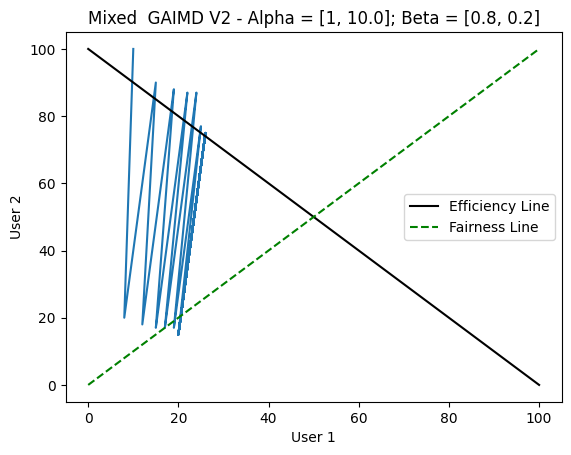

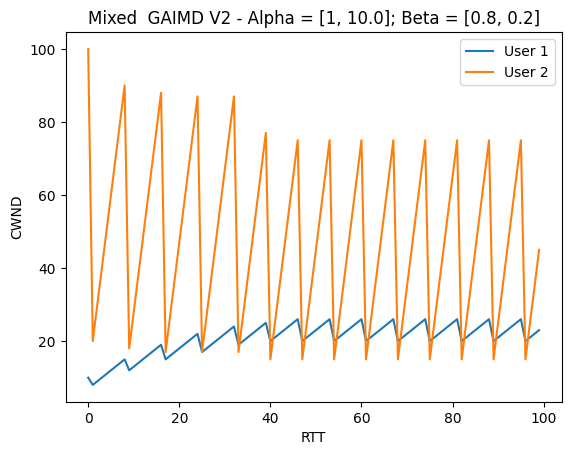

In [39]:
# Mixed GAIMD v2
# User 2 is more agreesive
ITERATESMAX = 100 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# Params
ALPHA = 1
BETA = 0.5

alphas = [1, 0.1*C]

betas = [0.8, 0.2]

init_cwnds = [10, 100]

# ssthresholds = [float('inf'), float('inf')]

# exponents = [1/3, 1/3]

# Users
num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(GAIMD(alphas[i], betas[i], init_cwnds[i]))

name = f"Mixed  GAIMD V2 - Alpha = {alphas}; Beta = {betas}"

run_simulation(ITERATESMAX, C, users, name)

Overall, a more agressive AIMD results in faster convergence but also more frequent congestion. On the other hand, a more friendly approach results in a longer time taken to converge, but there are fewer congestion events.

******************** Many users Aggressive GAIMD ********************
Initial User-1 CWND: 5
Initial User-2 CWND: 11
Initial User-3 CWND: 12
Initial User-4 CWND: 8
Initial User-5 CWND: 9
Initial User-6 CWND: 11
Initial User-7 CWND: 5
Initial User-8 CWND: 15
Initial User-9 CWND: 0
Initial User-10 CWND: 16
Initial User-11 CWND: 1
Initial User-12 CWND: 12
Initial User-13 CWND: 7
Initial User-14 CWND: 13
Initial User-15 CWND: 28
Initial User-16 CWND: 6
Initial User-17 CWND: 25
Initial User-18 CWND: 18
Initial User-19 CWND: 20
Initial User-20 CWND: 5
Multiplicative D at 0
Multiplicative D at 1
Multiplicative D at 2
Multiplicative D at 4
Multiplicative D at 5
Multiplicative D at 6
Multiplicative D at 7
Multiplicative D at 9
Multiplicative D at 10
Multiplicative D at 11
Multiplicative D at 12
Multiplicative D at 14
Multiplicative D at 15
Multiplicative D at 16
Multiplicative D at 17
Multiplicative D at 19
Multiplicative D at 20
Multiplicative D at 21
Multiplicative D at 22
Multiplicative D at

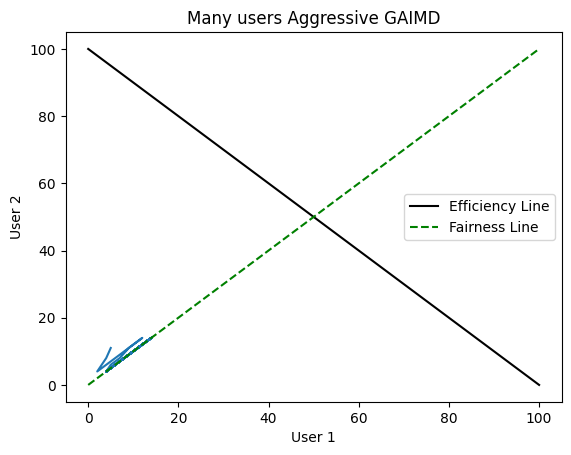

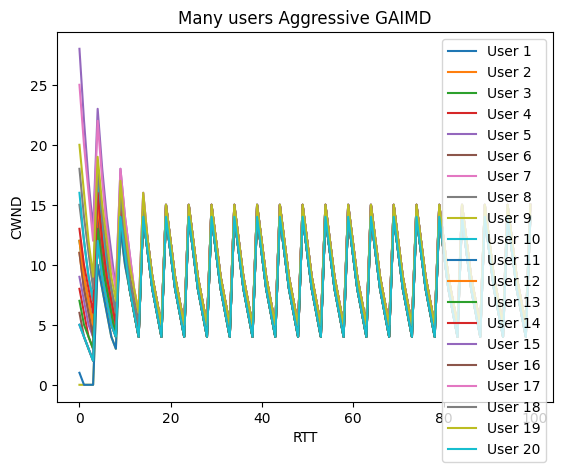

In [32]:
# Many Aggressive GAIMD
np.random.seed(1)
ITERATESMAX = 100 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# Params
ALPHA = 1
BETA = 0.5

num_users = 20

alphas = [0.1*C] * num_users

betas = [0.8] * num_users

init_cwnds = [np.random.randint(30) for i in range(num_users)]

# ssthresholds = [float('inf'), float('inf')]

# exponents = [1/3, 1/3]

# Users
# num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(GAIMD(alphas[i], betas[i], init_cwnds[i]))

name = "Many users Aggressive GAIMD"

run_simulation(ITERATESMAX, C, users, name)

An issue with the above is that it carries out MD phase of AIMD almost every RTT due to the many aggressive users. This is exacerbated by the high beta value, resulting in the users not losing much CWND, resulting in the network still being congested. Thus, it takes a while before finally reaching a suitable CWND amount to be shared among all users. However, once that valid CWND occurs, it then quickly rises up again. This may result in a low throughput as the network does not have the bandwidth for all these users.

******************** Many friendly GAIMD ********************
Initial User-1 CWND: 5
Initial User-2 CWND: 11
Initial User-3 CWND: 12
Initial User-4 CWND: 8
Initial User-5 CWND: 9
Initial User-6 CWND: 11
Initial User-7 CWND: 5
Initial User-8 CWND: 15
Initial User-9 CWND: 0
Initial User-10 CWND: 16
Initial User-11 CWND: 1
Initial User-12 CWND: 12
Initial User-13 CWND: 7
Initial User-14 CWND: 13
Initial User-15 CWND: 28
Initial User-16 CWND: 6
Initial User-17 CWND: 25
Initial User-18 CWND: 18
Initial User-19 CWND: 20
Initial User-20 CWND: 5
Multiplicative D at 0
Multiplicative D at 6
Multiplicative D at 13
Multiplicative D at 20
Multiplicative D at 27
Multiplicative D at 34
Multiplicative D at 41
Multiplicative D at 48
Multiplicative D at 55
Multiplicative D at 62
Multiplicative D at 69
Multiplicative D at 76
Multiplicative D at 83
Multiplicative D at 90
Multiplicative D at 97
Final User-1 CWND: 1
Final User-2 CWND: 1
Final User-3 CWND: 1
Final User-4 CWND: 1
Final User-5 CWND: 1
Final Us

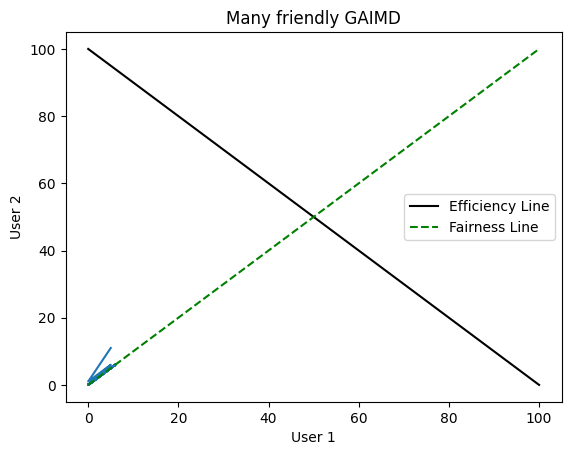

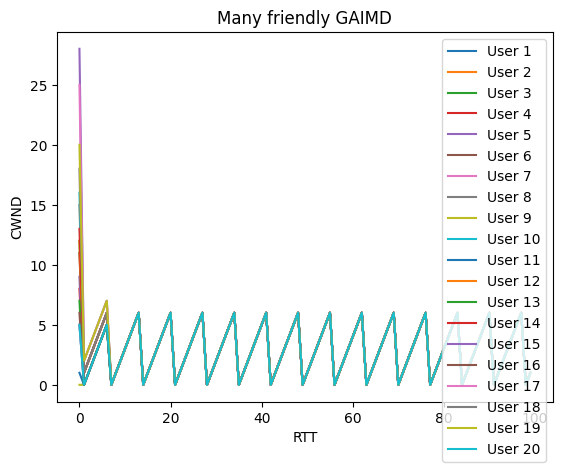

In [29]:
# Many friendly GAIMD
np.random.seed(1)
ITERATESMAX = 100 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# Params
ALPHA = 1
BETA = 0.5

num_users = 20

alphas = [1] * num_users

betas = [0.1] * num_users

init_cwnds = [np.random.randint(30) for i in range(num_users)]

# ssthresholds = [float('inf'), float('inf')]

# exponents = [1/3, 1/3]

# Users
# num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(GAIMD(alphas[i], betas[i], init_cwnds[i]))

name = "Many friendly GAIMD"

run_simulation(ITERATESMAX, C, users, name)

Congestion occurs every 7 RTT which is much lower than the many agressive users scenario. This may be a more suitable setting for a network of relatively low capacity with many users.

******************** Low Alpha, High beta GAIMD ********************
Initial User-1 CWND: 5
Initial User-2 CWND: 11
Initial User-3 CWND: 12
Initial User-4 CWND: 8
Initial User-5 CWND: 9
Initial User-6 CWND: 11
Initial User-7 CWND: 5
Initial User-8 CWND: 15
Initial User-9 CWND: 0
Initial User-10 CWND: 16
Initial User-11 CWND: 1
Initial User-12 CWND: 12
Initial User-13 CWND: 7
Initial User-14 CWND: 13
Initial User-15 CWND: 28
Initial User-16 CWND: 6
Initial User-17 CWND: 25
Initial User-18 CWND: 18
Initial User-19 CWND: 20
Initial User-20 CWND: 5
Multiplicative D at 0
Multiplicative D at 1
Multiplicative D at 2
Multiplicative D at 4
Multiplicative D at 6
Multiplicative D at 9
Multiplicative D at 11
Multiplicative D at 14
Multiplicative D at 16
Multiplicative D at 18
Multiplicative D at 21
Multiplicative D at 24
Multiplicative D at 26
Multiplicative D at 29
Multiplicative D at 32
Multiplicative D at 35
Multiplicative D at 38
Multiplicative D at 41
Multiplicative D at 44
Multiplicative D a

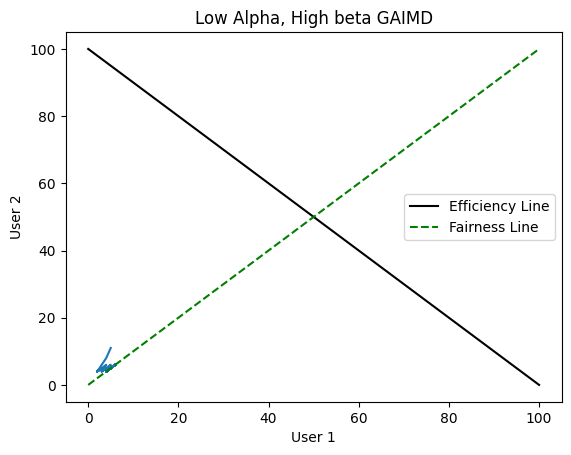

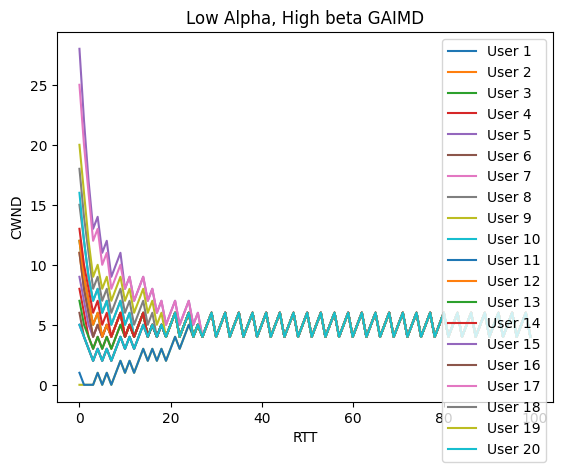

In [27]:
# Low Alpha, High beta GAIMD
np.random.seed(1)
ITERATESMAX = 100 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# Params
ALPHA = 1
BETA = 0.5

num_users = 20

alphas = [1] * num_users

betas = [0.8] * num_users

init_cwnds = [np.random.randint(30) for i in range(num_users)]

# ssthresholds = [float('inf'), float('inf')]

# exponents = [1/3, 1/3]

# Users
# num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(GAIMD(alphas[i], betas[i], init_cwnds[i]))

name = "Low Alpha, High beta GAIMD"

run_simulation(ITERATESMAX, C, users, name)

By using a more passive AI phase, and a higher beta value, this ensures that the bandwidth for the users reached are valid and can be accounted for.

******************** High Alpha, low beta GAIMD ********************
Initial User-1 CWND: 5
Initial User-2 CWND: 11
Initial User-3 CWND: 12
Initial User-4 CWND: 8
Initial User-5 CWND: 9
Initial User-6 CWND: 11
Initial User-7 CWND: 5
Initial User-8 CWND: 15
Initial User-9 CWND: 0
Initial User-10 CWND: 16
Initial User-11 CWND: 1
Initial User-12 CWND: 12
Initial User-13 CWND: 7
Initial User-14 CWND: 13
Initial User-15 CWND: 28
Initial User-16 CWND: 6
Initial User-17 CWND: 25
Initial User-18 CWND: 18
Initial User-19 CWND: 20
Initial User-20 CWND: 5
Multiplicative D at 0
Multiplicative D at 2
Multiplicative D at 4
Multiplicative D at 6
Multiplicative D at 8
Multiplicative D at 10
Multiplicative D at 12
Multiplicative D at 14
Multiplicative D at 16
Multiplicative D at 18
Multiplicative D at 20
Multiplicative D at 22
Multiplicative D at 24
Multiplicative D at 26
Multiplicative D at 28
Multiplicative D at 30
Multiplicative D at 32
Multiplicative D at 34
Multiplicative D at 36
Multiplicative D 

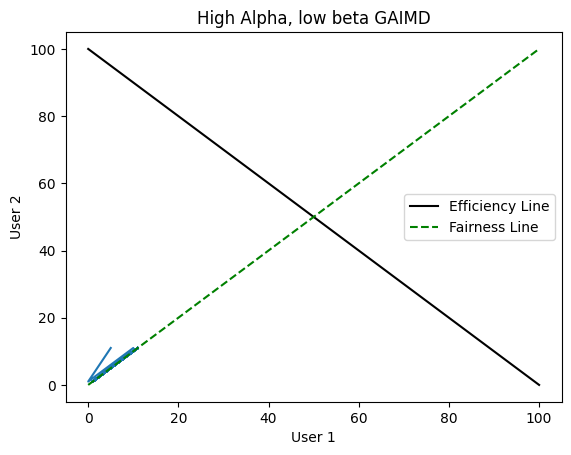

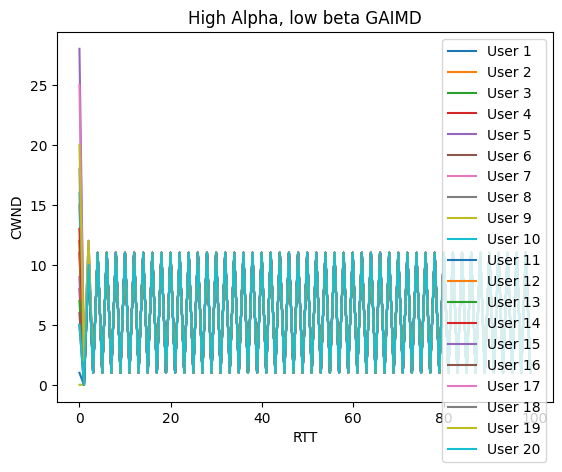

In [34]:
# High Alpha, low beta GAIMD
np.random.seed(1)
ITERATESMAX = 100 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# Params
ALPHA = 1
BETA = 0.5

num_users = 20

alphas = [10] * num_users

betas = [0.1] * num_users

init_cwnds = [np.random.randint(30) for i in range(num_users)]

# ssthresholds = [float('inf'), float('inf')]

# exponents = [1/3, 1/3]

# Users
# num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(GAIMD(alphas[i], betas[i], init_cwnds[i]))

name = "High Alpha, low beta GAIMD"

run_simulation(ITERATESMAX, C, users, name)

Every 2 RTTs after convergence, there is congestion

Considerations: <br>
The alpha and beta value should take into account the max capacity of the network. A high alpha value among users with a relatively low capacity results in constant congestion. This can be slightly mitigated by having a low beta value that helps to reduce the CWND of users. However, with the high alpha value, congestion will occur again quickly.

******************** Exponential AIMD ********************
Initial User-1 CWND: 10
Initial User-2 CWND: 90
Multiplicative D at 1
Multiplicative D at 5
Multiplicative D at 9
Multiplicative D at 12
Multiplicative D at 16
Multiplicative D at 20
Multiplicative D at 23
Multiplicative D at 27
Multiplicative D at 31
Multiplicative D at 34
Multiplicative D at 38
Multiplicative D at 42
Multiplicative D at 45
Multiplicative D at 49
Multiplicative D at 52
Multiplicative D at 56
Multiplicative D at 60
Multiplicative D at 63
Multiplicative D at 67
Multiplicative D at 71
Multiplicative D at 74
Multiplicative D at 78
Multiplicative D at 82
Multiplicative D at 85
Multiplicative D at 89
Multiplicative D at 92
Multiplicative D at 96
Multiplicative D at 100
Multiplicative D at 103
Multiplicative D at 107
Multiplicative D at 111
Multiplicative D at 114
Multiplicative D at 118
Multiplicative D at 122
Multiplicative D at 125
Multiplicative D at 129
Multiplicative D at 132
Multiplicative D at 136
Multiplicat

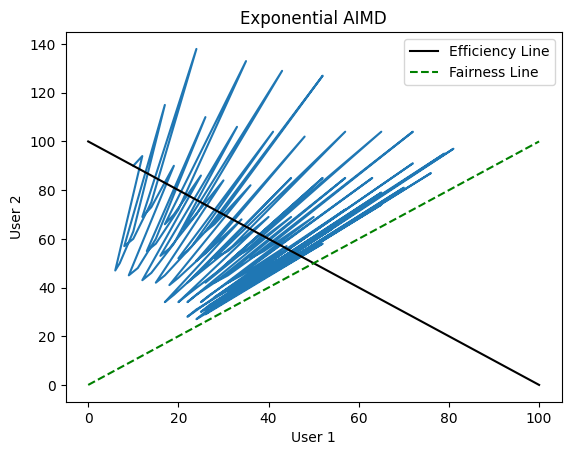

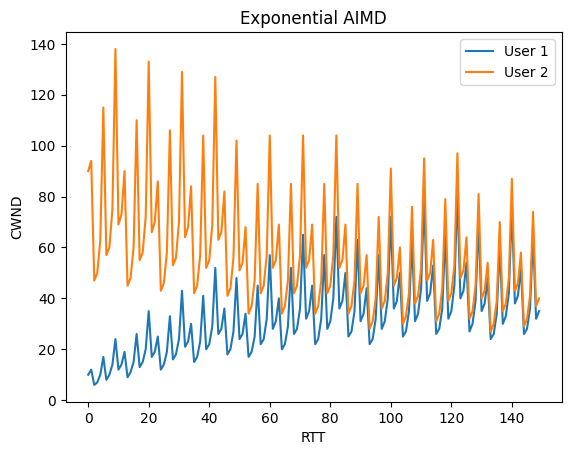

In [43]:
# Exponential
ITERATESMAX = 150 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# params
ALPHA = 1
BETA = 0.5

alphas = [1, 1]

betas = [0.5, 0.5]

init_cwnds = [10, 90]

ssthresholds = [float('inf'), float('inf')]

exponents = [1/3, 1/3]

# Users
num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(ExponentialAIMD(alphas[i], betas[i], init_cwnds[i], ssthresholds[i], exponents[i]))

name = "Exponential AIMD"
run_simulation(ITERATESMAX, C, users, name)

U1 and U2 do not attain the same value when starting at different CWND despite having the same parameters.

******************** Mixed Exponential AIMD ********************
Initial User-1 CWND: 1
Initial User-2 CWND: 1
Multiplicative D at 6
Multiplicative D at 7
Multiplicative D at 8
Multiplicative D at 9
Multiplicative D at 11
Multiplicative D at 14
Multiplicative D at 15
Multiplicative D at 18
Multiplicative D at 19
Multiplicative D at 20
Multiplicative D at 23
Multiplicative D at 24
Multiplicative D at 27
Multiplicative D at 28
Multiplicative D at 29
Multiplicative D at 32
Multiplicative D at 33
Multiplicative D at 35
Multiplicative D at 38
Multiplicative D at 39
Multiplicative D at 42
Multiplicative D at 43
Multiplicative D at 44
Multiplicative D at 47
Multiplicative D at 48
Multiplicative D at 51
Multiplicative D at 52
Multiplicative D at 53
Multiplicative D at 56
Multiplicative D at 57
Multiplicative D at 60
Multiplicative D at 61
Multiplicative D at 62
Multiplicative D at 65
Multiplicative D at 66
Multiplicative D at 68
Multiplicative D at 71
Multiplicative D at 72
Multiplicative D at

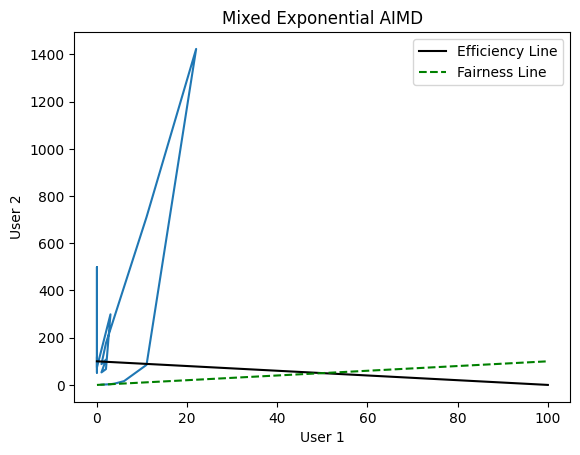

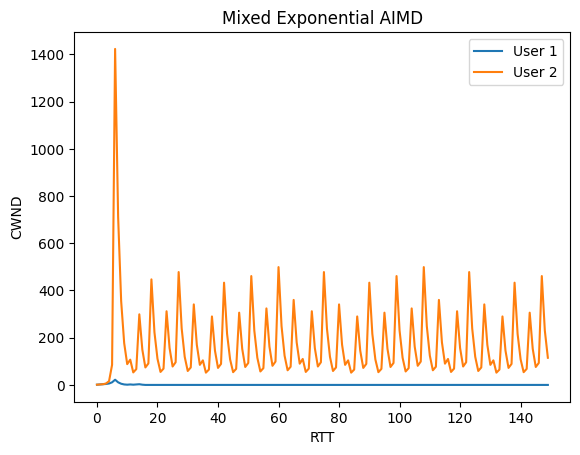

In [16]:
# Mixed Exponential
ITERATESMAX = 150 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# params
ALPHA = 1
BETA = 0.5

alphas = [1, 1]

betas = [0.5, 0.5]

init_cwnds = [1, 1]

ssthresholds = [float('inf'), float('inf')]

exponents = [1/3, 2/3]

# Users
num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(ExponentialAIMD(alphas[i], betas[i], init_cwnds[i], ssthresholds[i], exponents[i]))

name = "Mixed Exponential AIMD"
run_simulation(ITERATESMAX, C, users, name)

U1 becomes 0 eventually resulting in them not having a share in the network.

******************** Mixed Exponential AIMD ********************
Initial User-1 CWND: 1
Initial User-2 CWND: 1
Multiplicative D at 6
Multiplicative D at 7
Multiplicative D at 10
Multiplicative D at 13
Multiplicative D at 16
Multiplicative D at 19
Multiplicative D at 22
Multiplicative D at 24
Multiplicative D at 27
Multiplicative D at 30
Multiplicative D at 33
Multiplicative D at 36
Multiplicative D at 39
Multiplicative D at 41
Multiplicative D at 44
Multiplicative D at 47
Multiplicative D at 50
Multiplicative D at 53
Multiplicative D at 56
Multiplicative D at 58
Multiplicative D at 61
Multiplicative D at 64
Multiplicative D at 67
Multiplicative D at 70
Multiplicative D at 73
Multiplicative D at 75
Multiplicative D at 78
Multiplicative D at 81
Multiplicative D at 84
Multiplicative D at 87
Multiplicative D at 90
Multiplicative D at 92
Multiplicative D at 95
Multiplicative D at 98
Multiplicative D at 101
Multiplicative D at 104
Multiplicative D at 107
Multiplicative D at 109
Multiplicativ

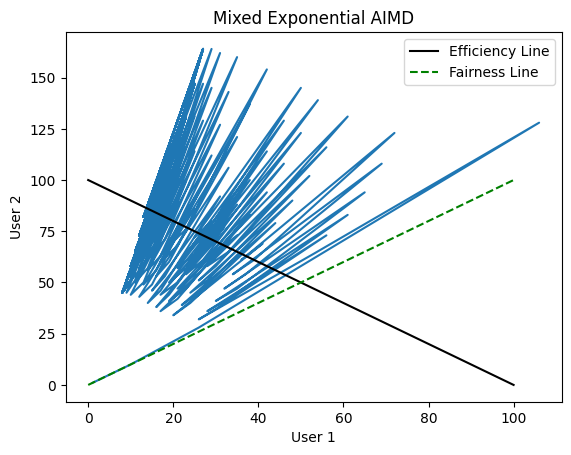

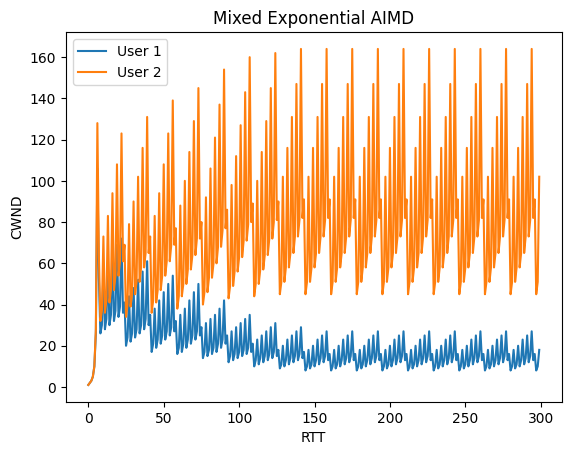

In [17]:
# Mixed Exponential
ITERATESMAX = 300 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# params
ALPHA = 1
BETA = 0.5

alphas = [1, 1]

betas = [0.5, 0.5]

init_cwnds = [1, 1]

ssthresholds = [float('inf'), float('inf')]

exponents = [0.49, 0.51]

# Users
num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(ExponentialAIMD(alphas[i], betas[i], init_cwnds[i], ssthresholds[i], exponents[i]))

name = "Mixed Exponential AIMD"
run_simulation(ITERATESMAX, C, users, name)

Even with a very minor difference in exponent values (and same parameters values), the resultant network favors U2 much more than U1.

******************** Many users Exponential AIMD ********************
Initial User-1 CWND: 19
Initial User-2 CWND: 21
Initial User-3 CWND: 12
Initial User-4 CWND: 29
Initial User-5 CWND: 11
Initial User-6 CWND: 29
Initial User-7 CWND: 15
Initial User-8 CWND: 19
Initial User-9 CWND: 5
Initial User-10 CWND: 24
Multiplicative D at 0
Multiplicative D at 2
Multiplicative D at 6
Multiplicative D at 9
Multiplicative D at 13
Multiplicative D at 16
Multiplicative D at 19
Multiplicative D at 23
Multiplicative D at 26
Multiplicative D at 30
Multiplicative D at 33
Multiplicative D at 36
Multiplicative D at 40
Multiplicative D at 43
Multiplicative D at 46
Multiplicative D at 50
Multiplicative D at 53
Multiplicative D at 57
Multiplicative D at 60
Multiplicative D at 64
Multiplicative D at 67
Multiplicative D at 71
Multiplicative D at 74
Multiplicative D at 78
Multiplicative D at 81
Multiplicative D at 85
Multiplicative D at 88
Multiplicative D at 92
Multiplicative D at 95
Multiplicative D at 99
Mult

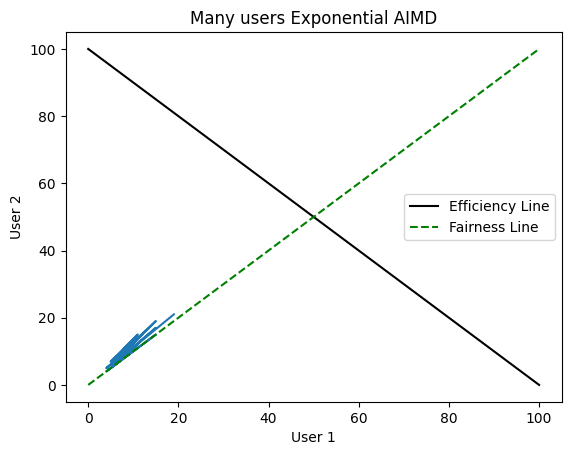

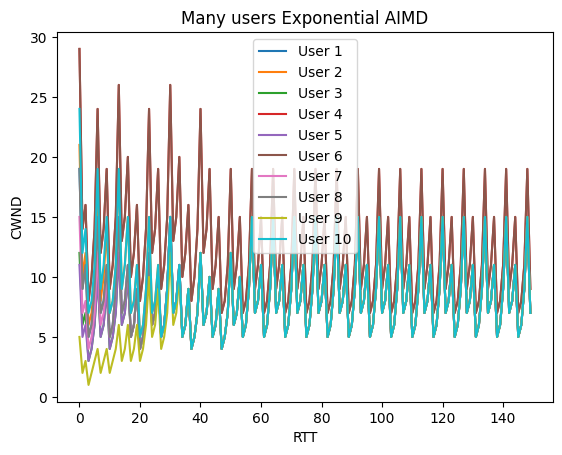

In [18]:
# Many users Mixed Exponential AIMD
ITERATESMAX = 150 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# params
ALPHA = 1
BETA = 0.5

# Users
num_users = 10
users = []

alphas = [1] * num_users

betas = [0.5] * num_users

init_cwnds = [np.random.randint(1, 30) for i in range(num_users)]

ssthresholds = [float('inf')] * num_users

exponents = [1/3] * num_users


for i in range(num_users):
    users.append(ExponentialAIMD(alphas[i], betas[i], init_cwnds[i], ssthresholds[i], exponents[i]))

name = "Many users Exponential AIMD"
run_simulation(ITERATESMAX, C, users, name)

Very dependent on who starts with the greater initial CWND. Those at the lower end are shown to greatly lose priority in the network and tend to result in having no share.

******************** Log AIMD ********************
Initial User-1 CWND: 10
Initial User-2 CWND: 20
Multiplicative D at 3
Multiplicative D at 7
Multiplicative D at 10
Multiplicative D at 14
Multiplicative D at 17
Multiplicative D at 21
Multiplicative D at 24
Multiplicative D at 28
Multiplicative D at 31
Multiplicative D at 35
Multiplicative D at 38
Multiplicative D at 42
Multiplicative D at 45
Multiplicative D at 49
Multiplicative D at 52
Multiplicative D at 56
Multiplicative D at 59
Multiplicative D at 63
Multiplicative D at 66
Multiplicative D at 70
Multiplicative D at 73
Multiplicative D at 77
Multiplicative D at 80
Multiplicative D at 84
Multiplicative D at 87
Multiplicative D at 91
Multiplicative D at 94
Multiplicative D at 98
Final User-1 CWND: 47
Final User-2 CWND: 47


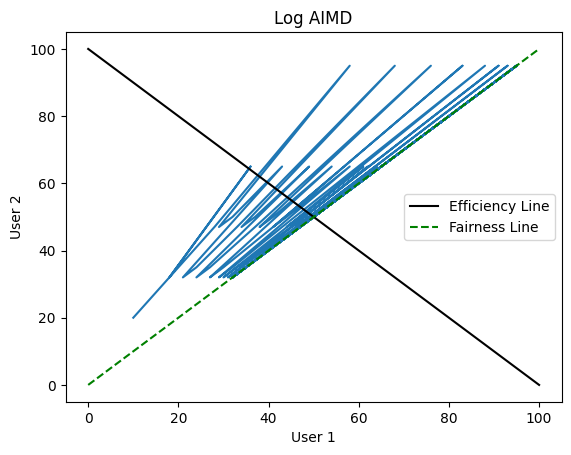

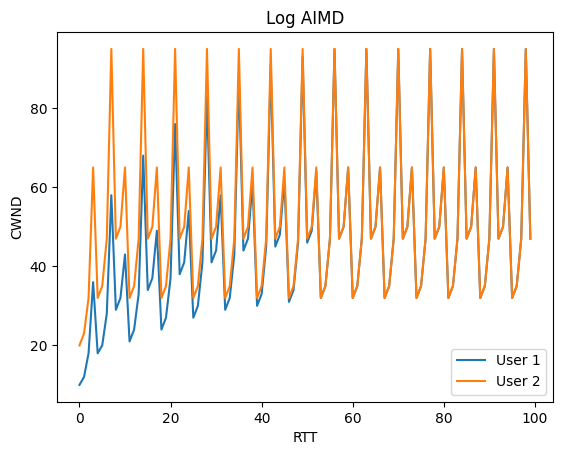

In [19]:
# Log
ITERATESMAX = 100 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# params
ALPHA = 1
BETA = 0.5

alphas = [1, 1]

betas = [0.5, 0.5]

init_cwnds = [10, 20]

ssthresholds = [float('inf'), float('inf')]

# exponents = [1/3, 1/3]

# Users
num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(LogAIMD(alphas[i], betas[i], init_cwnds[i], ssthresholds[i]))

name = "Log AIMD"
run_simulation(ITERATESMAX, C, users, name)

Behaves similarly to normal AIMD;however, it converges much faster (around 56 RTT compared to 142 for standard AIMD). MD every 3-4 RTTs

******************** Log AIMD ********************
Initial User-1 CWND: 10
Initial User-2 CWND: 20
Multiplicative D at 2
Multiplicative D at 3
Multiplicative D at 5
Multiplicative D at 7
Multiplicative D at 9
Multiplicative D at 11
Multiplicative D at 13
Multiplicative D at 15
Multiplicative D at 17
Multiplicative D at 19
Multiplicative D at 21
Multiplicative D at 23
Multiplicative D at 25
Multiplicative D at 27
Multiplicative D at 29
Multiplicative D at 31
Multiplicative D at 33
Multiplicative D at 35
Multiplicative D at 37
Multiplicative D at 39
Multiplicative D at 41
Multiplicative D at 43
Multiplicative D at 45
Multiplicative D at 47
Multiplicative D at 49
Multiplicative D at 51
Multiplicative D at 53
Multiplicative D at 55
Multiplicative D at 57
Multiplicative D at 59
Multiplicative D at 61
Multiplicative D at 63
Multiplicative D at 65
Multiplicative D at 67
Multiplicative D at 69
Multiplicative D at 71
Multiplicative D at 73
Multiplicative D at 75
Multiplicative D at 77
Multiplic

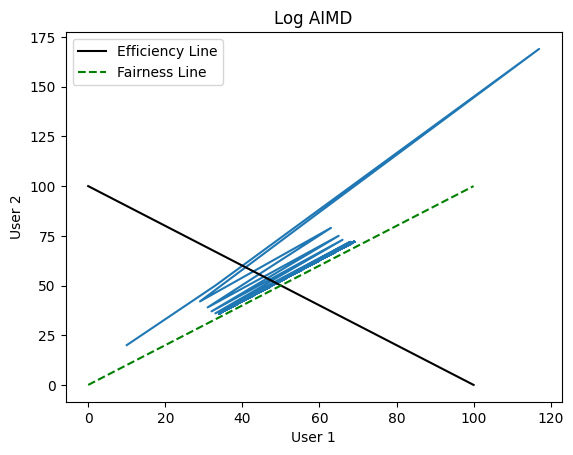

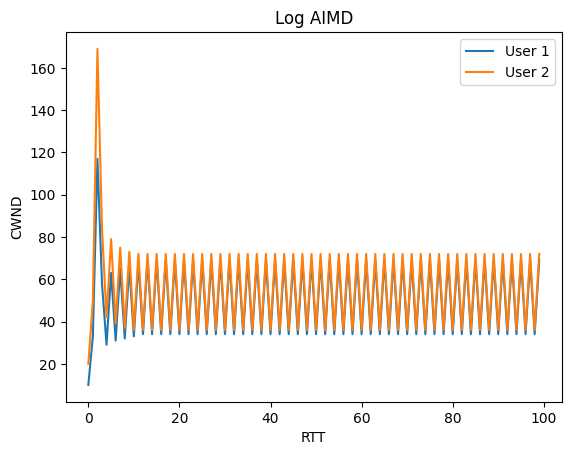

In [20]:
# Log
ITERATESMAX = 100 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# params
ALPHA = 1
BETA = 0.5

alphas = [0.1*C, 0.1*C]

betas = [0.5, 0.5]

init_cwnds = [10, 20]

ssthresholds = [float('inf'), float('inf')]

# exponents = [1/3, 1/3]

# Users
num_users = len(alphas)
users = []

for i in range(num_users):
    users.append(LogAIMD(alphas[i], betas[i], init_cwnds[i], ssthresholds[i]))

name = "Log AIMD"
run_simulation(ITERATESMAX, C, users, name)

Behaves similarly to that of normal AIMD

******************** Exponential+Log AIMD ********************
Initial User-1 CWND: 4
Initial User-2 CWND: 50
Multiplicative D at 3
Multiplicative D at 7
Multiplicative D at 10
Multiplicative D at 14
Multiplicative D at 17
Multiplicative D at 21
Multiplicative D at 25
Multiplicative D at 28
Multiplicative D at 32
Multiplicative D at 35
Multiplicative D at 39
Multiplicative D at 42
Multiplicative D at 46
Multiplicative D at 49
Multiplicative D at 53
Multiplicative D at 57
Multiplicative D at 60
Multiplicative D at 64
Multiplicative D at 67
Multiplicative D at 71
Multiplicative D at 74
Multiplicative D at 78
Multiplicative D at 81
Multiplicative D at 85
Multiplicative D at 89
Multiplicative D at 91
Multiplicative D at 95
Final User-1 CWND: 45
Final User-2 CWND: 141


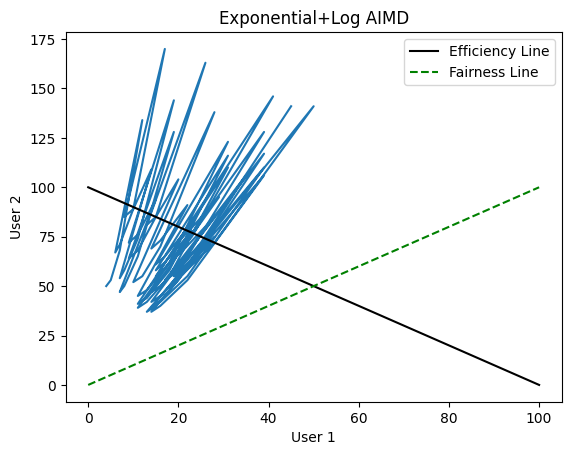

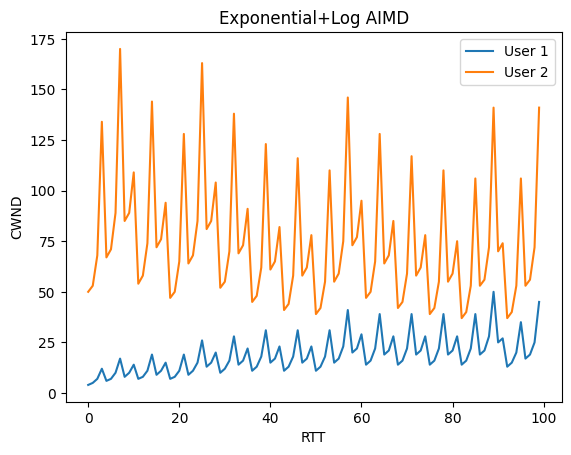

In [48]:
# Exponential+Log
ITERATESMAX = 100 # You can adjust this value as needed
# Max Capacity of the network
C = 100

# params
ALPHA = 1
BETA = 0.5


# Exponent users
ex_alphas = [1]

ex_betas = [0.5]

ex_init_cwnds = [4]

ex_ssthresholds = [float('inf')]

exponents = [1/3]

# Log users
log_alphas = [1]

log_betas = [0.5]

log_init_cwnds = [50]

log_ssthresholds = [float('inf')]

# Users
num_ex_users = len(exponents)
num_log_users = len(log_alphas)

users = []

for i in range(num_ex_users):
    users.append(ExponentialAIMD(ex_alphas[i], ex_betas[i], ex_init_cwnds[i], ex_ssthresholds[i], exponents[i]))
for i in range(num_log_users):
    users.append(LogAIMD(log_alphas[i], log_betas[i], log_init_cwnds[i], log_ssthresholds[i]))

name = "Exponential+Log AIMD"
run_simulation(ITERATESMAX, C, users, name)